# Lab 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)
### Шевченко Юлія, ФІ-31мн

### Lab Task:

1. _**Зниження розмірності і візуалізація даних**_. Застосувати методи зниження розмірності sklearn.decomposition.PCA і sklearn.manifold.TSNE для візуалізації даних, з якими працювали в лабораторній №1 (знижуючи розмірність до двох). Візуалізувати результат.
2. _**Кластерний аналіз**_. За допомогою алгоритму k-means зробити квантування зображення (видалення візуально надлишкової інформації) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення.
3. _**Обробка та класифікація текстових даних**_. Завантажити набір текстових даних (з мітками класів). Провести передобробку даних (видалити стоп-слова, пунктуацію), за допомогою wordcloud зробити візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизувати тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). Провести класифікацію текстових даних, зробити оцінку якості.

In [1]:
# All the imports for the task
import re
import string

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

### Dimensionality Reduction

In [2]:
# Loading dataset from csv from Lab 1
spotify_data = pd.read_csv('../Lab_1/song_data.csv')

In [3]:
# Showing the dataset
spotify_data.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

In [4]:
# Showing the dataset columns
print('The dataset contains such columns: {}'.format(spotify_data.columns))

The dataset contains such columns: Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')


In [5]:
# Considering song is popular if song_popularity value is >= 70
spotify_data['popularity'] = [1 if value >= 70 else 0 for value in spotify_data.song_popularity]

### PCA (Principal Component Analysis)

In [6]:
# Choosing numeric data
spotify_data_numeric = spotify_data.select_dtypes(include = ['float64', 'int64'])

In [7]:
# Standardize the variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spotify_data_numeric)

In [8]:
# PCA model
PCA_model = PCA()
PCA_result = PCA_model.fit_transform(scaled_data)

In [9]:
# Calculating EVR
EVR = PCA_model.explained_variance_ratio_
evr_cumsum = np.cumsum(EVR)

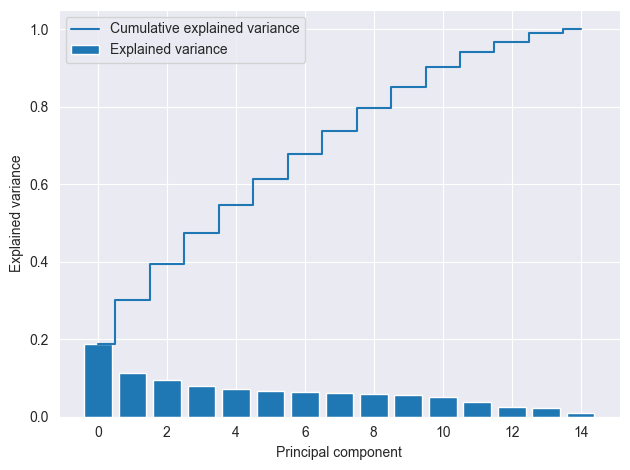

In [10]:
# Visualizing the results
plt.bar(range(0, len(EVR)), EVR, align='center', label='Explained variance')
plt.step(range(0, len(evr_cumsum)), evr_cumsum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

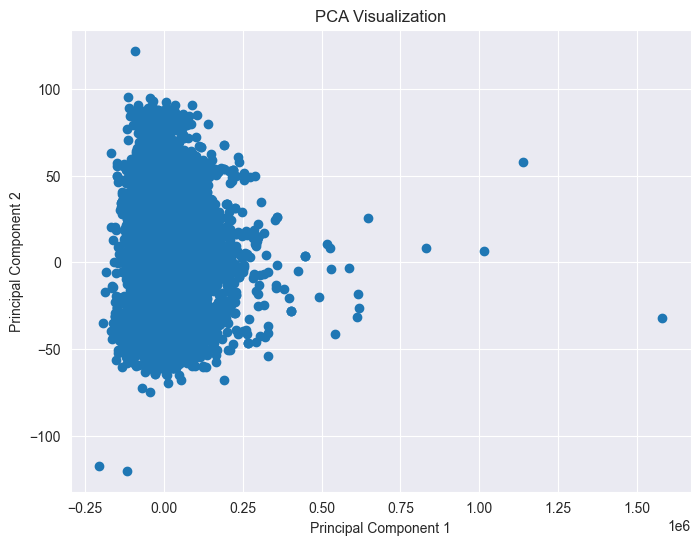

In [11]:
X = spotify_data_numeric.drop(['popularity'], axis=1)
y = spotify_data_numeric['popularity']

PCA_model = PCA(n_components=2)
PCA_result = PCA_model.fit_transform(X)

# Plot the transformed data using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(PCA_result[:, 0], PCA_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()

### tSNE

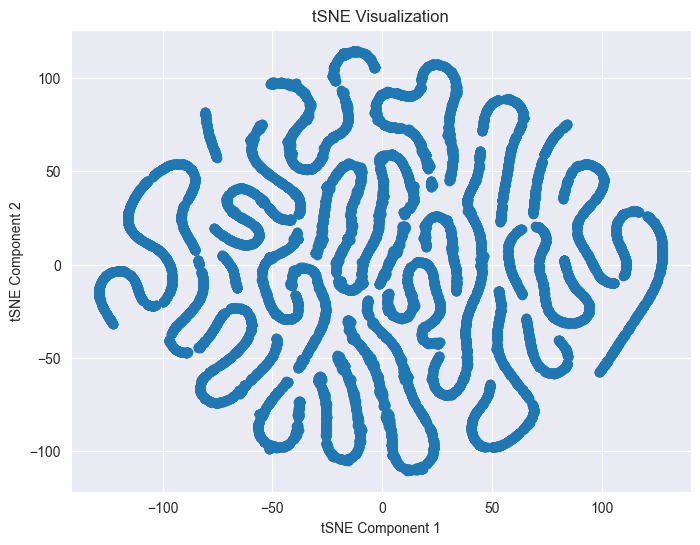

In [12]:
X = spotify_data_numeric.drop(['popularity'], axis=1)
y = spotify_data_numeric['popularity']

tSNE_model = TSNE(n_components=2)
tSNE_result = tSNE_model.fit_transform(X)

# Plot the transformed data using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(tSNE_result[:, 0], tSNE_result[:, 1])
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.title('tSNE Visualization')
plt.show()

### K-Means Clustering

In [13]:
# Loading photo
image_path = '../Lab_2/singapore.jpg'
img = cv2.imread(image_path)

In [14]:
# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

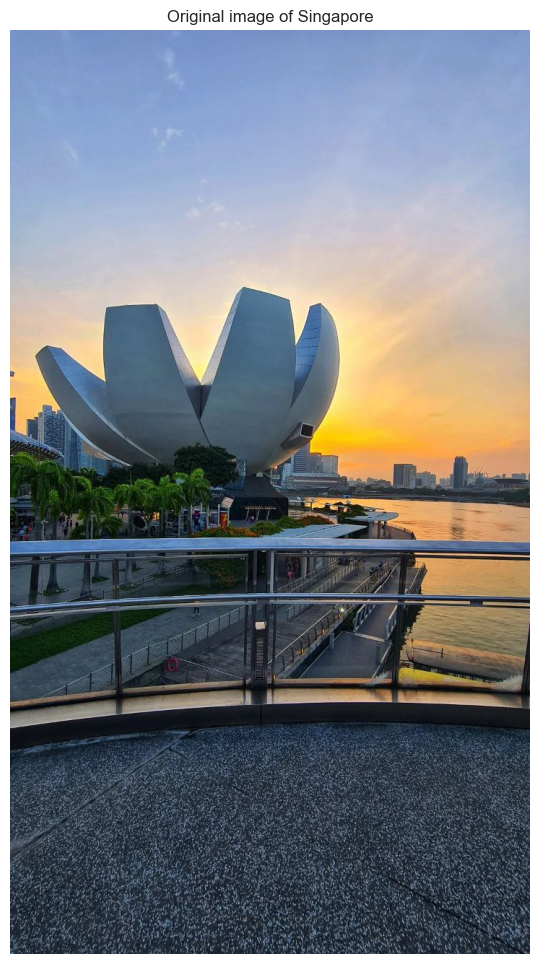

In [15]:
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.title('Original image of Singapore')
plt.axis('off')
plt.show()

In [16]:
# Reshape the image to a 2D array of pixels
pixels = img.reshape((-1, 3))

In [17]:
# Defining function to provide color quantization using K-Means
def color_quantization_kmeans(image_pixels, depth):
    kmeans = KMeans(n_clusters=depth, n_init='auto').fit(image_pixels)
    quantized_palette = kmeans.cluster_centers_.astype(np.uint8)
    labels = kmeans.labels_
    result_img = quantized_palette[labels].reshape(img.shape)
    
    return result_img

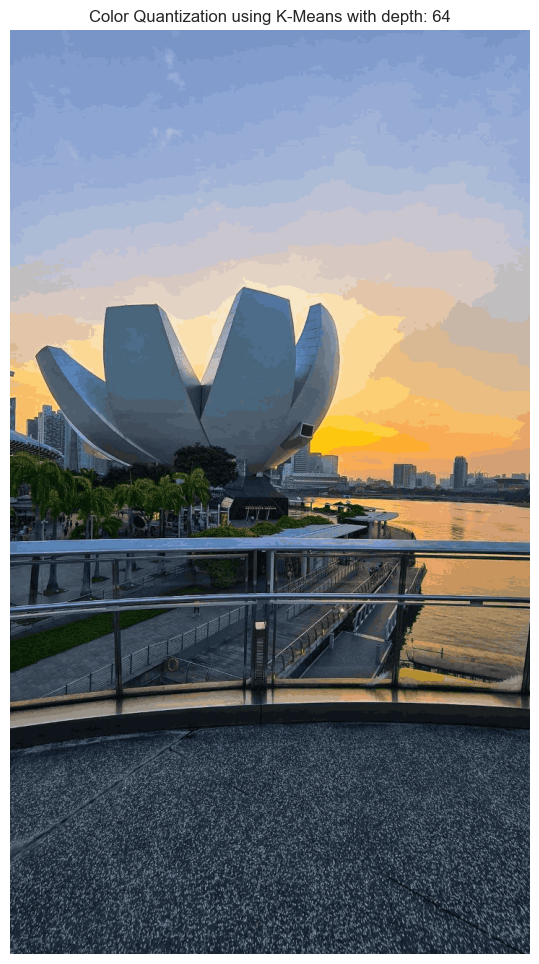

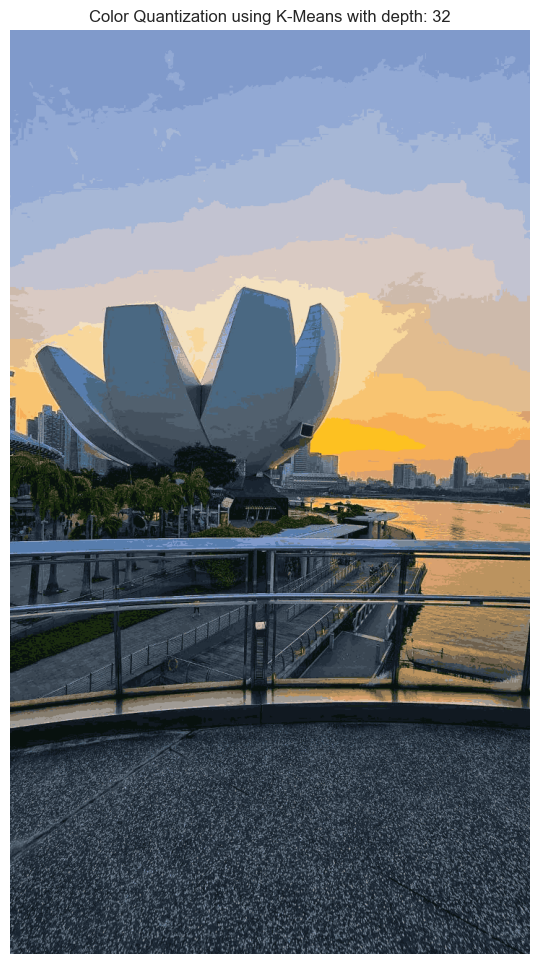

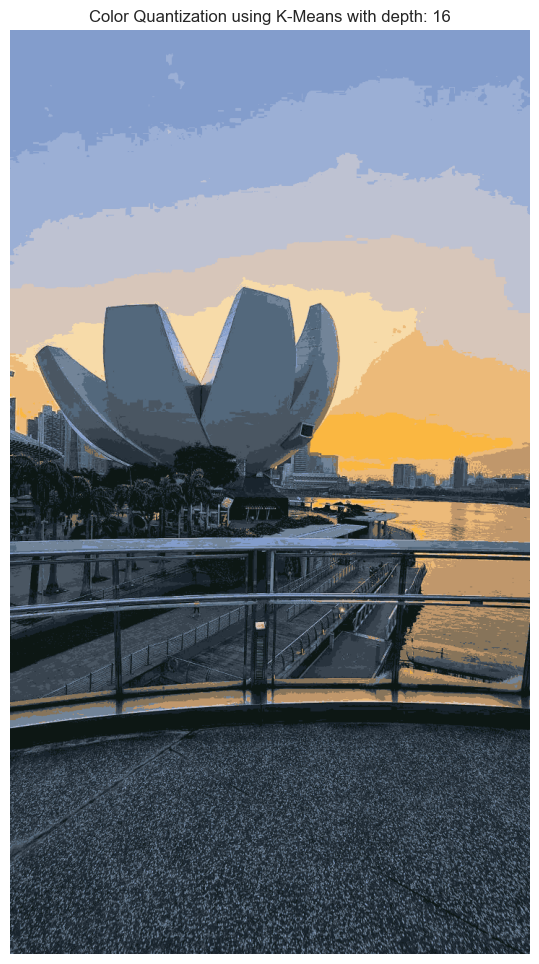

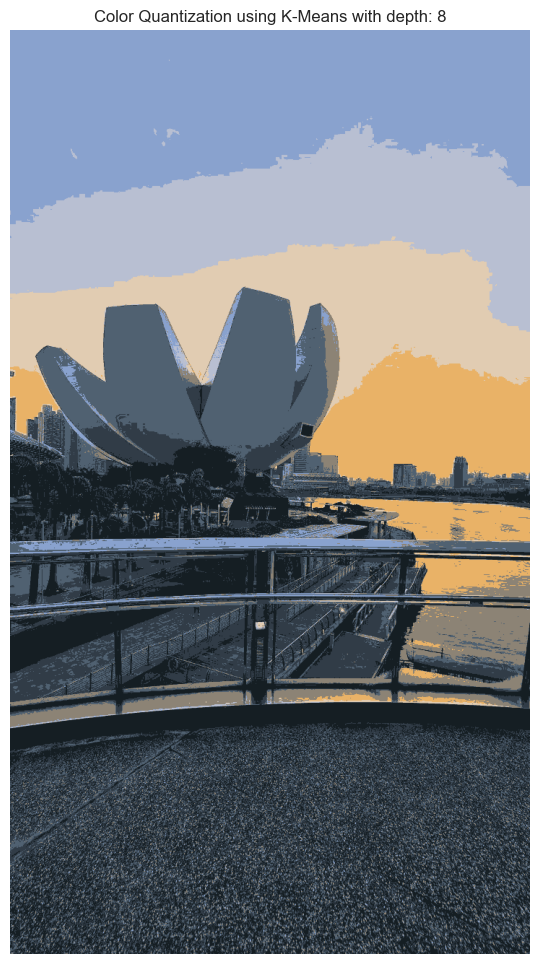

In [18]:
depths = [64, 32, 16, 8]

# Perform color quantization for each level of depth and display the images
for depth in depths:
    quantized_image = color_quantization_kmeans(pixels, depth)
    plt.figure(figsize=(12, 12))
    plt.imshow(quantized_image)
    plt.title('Color Quantization using K-Means with depth: {}'.format(depth))
    plt.axis('off')
    plt.show()

### Text cleaning and classification

For this task I decided to choose '[Cyberbullying Classification](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data)' from Kaggle.
As social media usage becomes increasingly prevalent in every age group, a vast majority of citizens rely on this essential medium for day-to-day communication. Social media’s ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere, and the relative anonymity of the internet makes such personal attacks more difficult to stop than traditional bullying. On April 15th, 2020, UNICEF issued a warning in response to the increased risk of cyberbullying during the COVID-19 pandemic due to widespread school closures, increased screen time, and decreased face-to-face social interaction. The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:
1. Age;
2. Ethnicity;
3. Gender;
4. Religion;
5. Other type of cyberbullying;
6. Not cyberbullying

The data has been balanced in order to contain ~8000 of each class.

In [19]:
# Loading dataset from csv
tweet_data = pd.read_csv('../Lab_2/cyberbullying_tweets.csv')

In [20]:
# Showing the dataset
tweet_data.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

In [21]:
# Checking info about data in columns
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [22]:
# Checking if there are some null items in dataset
print('Dataset null summarization:')
tweet_data.isnull().sum()

Dataset null summarization:


tweet_text            0
cyberbullying_type    0
dtype: int64

In [23]:
# Checking if there are duplicated items
tweet_data.duplicated().sum()

36

In [24]:
# Remove duplicated items
tweet_data.drop_duplicates(inplace=True)

In [25]:
# Show the amount of items for every class of cyberbullying_type
tweet_data['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [26]:
# Function for tweet text preprocessing with cleaning, stop words filtration and stemming
def data_preprocessing(tweet_text):
    # Convert to lowercase
    tweet_text = tweet_text.lower()
    # Remove Twitter usernames
    tweet_text = re.sub('@\S+', ' ', tweet_text)
    # Remove hashtags
    tweet_text = re.sub('#\S+', ' ', tweet_text)
    # Remove URLs
    tweet_text = re.sub('https*\S+', ' ', tweet_text)
    # Remove numbers
    tweet_text = re.sub('\d', ' ', tweet_text)
    # Remove punctuations
    tweet_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet_text)
    # Remove extra spaces
    tweet_text = re.sub('\s{2,}', ' ', tweet_text)
    
    # Stop words filtration
    words = word_tokenize(tweet_text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    processed_tweet = ' '.join(words)
    
    return processed_tweet

In [27]:
# Applying preprocessing
tweet_data['tweet_text'] = tweet_data['tweet_text'].apply(data_preprocessing)

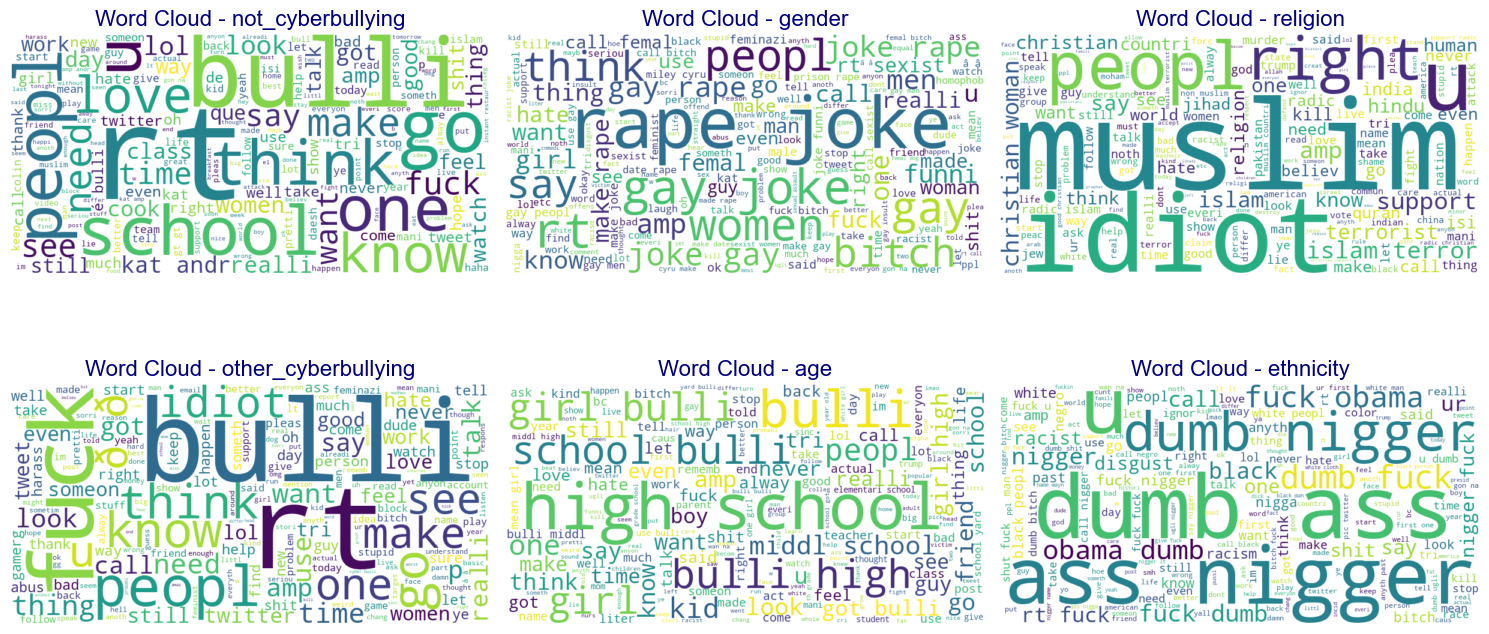

In [28]:
# Building wordclouds for every class from cyberbullying_type
categories = tweet_data['cyberbullying_type'].unique()

plt.figure(figsize=(15, 8))

for i, category in enumerate(categories):
    text = tweet_data[tweet_data['cyberbullying_type'] == category]['tweet_text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {category}', fontsize=16, color='navy')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [29]:
# Splitting data to train and test with 20% test data size
X_train, X_test, y_train, y_test = train_test_split(tweet_data['tweet_text'], tweet_data['cyberbullying_type'], test_size=0.2)

In [30]:
# Vectorization with TFIDF
TFIDF_vectorizer = TfidfVectorizer()
TFIDF_vectorizer.fit(tweet_data['tweet_text'])
X_train_vecs = TFIDF_vectorizer.transform(X_train)
X_test_vecs  = TFIDF_vectorizer.transform(X_test)

In [31]:
# Text data classifier
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'AdaBoost': AdaBoostClassifier()
}

for name, classifier in classifiers.items():
    classifier.fit(X_train_vecs, y_train)
    classifier_prediction = classifier.predict(X_test_vecs)
    
    classifier_confusion_matrix = confusion_matrix(y_test, classifier_prediction)
    classifier_report = classification_report(y_test, classifier_prediction)
    
    print('--------------------{}--------------------'.format(name))
    print('Confusion Matrix:')
    print(classifier_confusion_matrix)
    print('Classification Report:')
    print(classifier_report)
    print()

--------------------Logistic Regression--------------------
Confusion Matrix:
[[1529    2    2   39   17    1]
 [   1 1571    5   12   16    4]
 [  10    4 1312  124  144    7]
 [  46   13   47  902  543   50]
 [  27   17   70  444 1002   15]
 [   4    3    2   60   17 1470]]
Classification Report:
                     precision    recall  f1-score   support

                age       0.95      0.96      0.95      1590
          ethnicity       0.98      0.98      0.98      1609
             gender       0.91      0.82      0.86      1601
  not_cyberbullying       0.57      0.56      0.57      1601
other_cyberbullying       0.58      0.64      0.60      1575
           religion       0.95      0.94      0.95      1556

           accuracy                           0.82      9532
          macro avg       0.82      0.82      0.82      9532
       weighted avg       0.82      0.82      0.82      9532

--------------------Decision Tree--------------------
Confusion Matrix:
[[1541    3    